# 2 - Frequency Domain Speech Analysis

In [1]:
include("./JuliaImpl/SSP.jl");
include("./JuliaImpl/Sheet1.jl");
include("./JuliaImpl/Sheet2.jl");
using Plots;
pyplot();

## 1 Short-time Fourier transform

In [2]:
speech1 = SSP.loadAudio("../Exercise2/Audio/speech1.wav");
phone = SSP.loadAudio("../Exercise2/Audio/phone.wav");

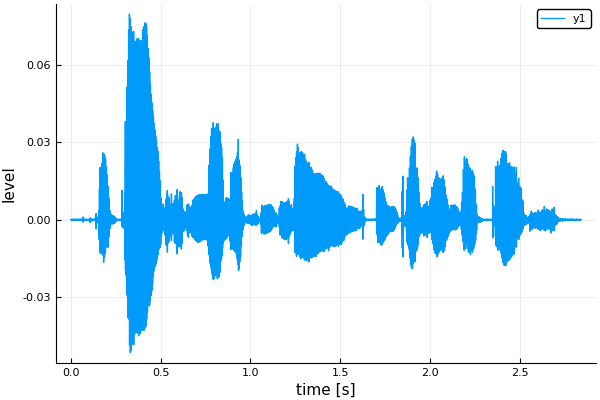

In [3]:
SSP.plotAudio(speech1)

We extract from `speech1` the vector of samples `s` and extract a voiced segment `t`.

In [4]:
s = speech1.samples[:,1];
t = s[5100:5900];
T = fft(t)

_T = vcat(fft(t),fft(t)[1]);
reversed_T = conj(reverse(_T));

The imaginary parts match:

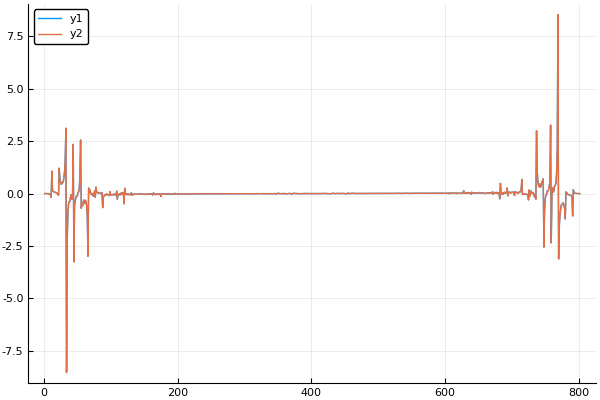

In [5]:
plot([imag.(_T),imag.(reversed_T)])

The real parts match, too:

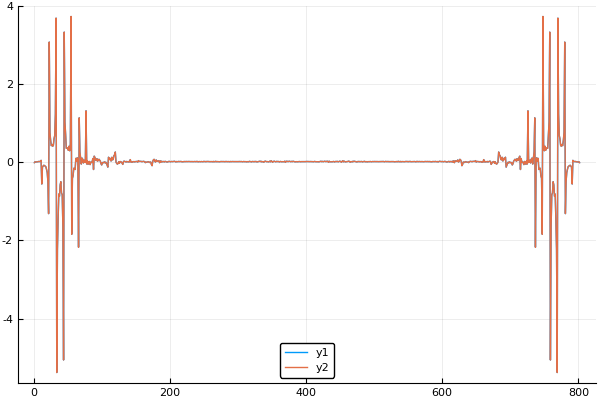

In [6]:
plot([real.(_T),real.(reversed_T)])

We find that the maximal deviation between a fourier transform `T` of `t` and its conjugate reverse `reversed_T` is at most

In [7]:
maximum(abs.(_T - reversed_T))

1.7763568394002505e-15

Note the __symmetry of the spectrum__.

The spectrum is (conjugate-)symmetric as Fourier transformation maps complex conjugation to inversion:
$$F(\overline{f})(\chi) = \int \overline{f} \overline{\chi} = \overline{\int f\overline{\chi^{-1}}} = \overline{F(f)(\chi^{-1})}$$

Note that for characters $\chi^{-1} = \overline{\chi}$ holds.

Because $f = \overline{f}$ for real function $f$, we have $F(f)(i) = F(\overline{f})(i) = \overline{F(f)(-i)}$.

This shows: one half of the spectrum is __redundant__!
Even though one might think that the Fourier transform takes twice as much space due to the use of complex numbers, can store it using just as much space as the input signal.

To make this precise, consider firstly the case where the input vector has even length $N=2n+2$.
Then the bins at index $1$ and $n+1$ are real, whereas the bins at indices $2,...,n$ are complex.
A quick dimension count shows that this makes sense:
The Fourier transform constitutes an isomorphism of real vector spaces.
The input has dimension $2n+2$ and the output has the same dimension $1 + 2n + 1$ (two real bins and $n$ complex bins).
All in all, we need to grab the indices $1,...,n+1,n+2$ which can be written $1,...,\lfloor N/2\rfloor + 1$.

For the odd case $N=2n+1$ we only have one real-valued bin at index $1$ and we need to grab $n$ complex valued bins at indices $2,...,n+1$.
Hence we can truncate the Fourier transform to indices $1,...,n+1$ or equivalently $1,...,\lfloor N/2\rfloor + 1$

__To include the Nyquist bin we therefore need $\lfloor N/2\rfloor + 1$ consecutive spectral bins.__

Now consider the (absolute value of the) truncated Fourier transform.

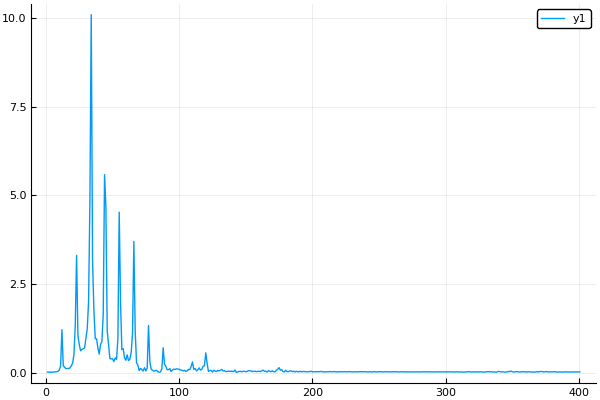

In [8]:
truncated_T = T[1:floor(Int,length(T)/2)+1]
plot(abs.(truncated_T))

The first peak is the fundamental frequency (it is at 12, and there are 12 periods in the frame in question).
Thereafter we find the overtones at $11*k, k =2,...,8,10,11 $ (roughly speaking)
To know the frequency assigned to bin 12, we just have to remember what the bin means.
It is the coefficient of the complex oscillation described by $t \mapsto e^{2\pi * (12-1)*t/N}$, which tells us that the oscillation repeats $12$ times during the duration of the signal.

Now consider the `k`-th bin.
We get with `N = numSamples(audio)` that the duration of the signal is `numSamples(audio) / samplingRate(audio)` seconds.
Hence the frequency is of the `k`-th bin is

```julia
(k-1) / (numSamples(audio) * samplingRate(audio))
```

```julia
# ./JuliaImpl/Sheet2.jl
function my_stft(faudio::FramedAudio)
    num_spf     = numSamples(faudio)
    truncation  = floor(Int, (numSamples(faudio) + 1) / 2)
    K = 1:truncation
    frequencies = (K-1) * samplingRate(faudio) / numSamples(faudio)

    dft_frames = zeros(Complex{Float64},
                       truncation,
                       numTracks(faudio),
                       numFrames(faudio))
    for i in 1:numFrames(faudio)
        frame    = faudio.frames[:,:,i]
        spectrum = fft(frame)
        dft_frames[:,:,i] = spectrum[1:truncation,:]
    end

    FramedSpectrum(dft_frames, samplingRate(faudio), faudio.mean_time,
                   frequencies, faudio.spf, faudio.sps,
                   numSamples(faudio))
end

```


## 2 Spectral Analysis

### (a)

The function `Windows.hanning` of the `DSP` generates Hann windows.
In order to make shifts of these windows add up to 1, we need to modify the Hann window slightly.
This should give us an "ideal" Hann window:

```julia
# ./JuliaImpl/Sheet2.jl
function myHann(n)
    N = n % 2 == 0 ? n + 1 : n
    Windows.hanning(N)[1:n]
end
```

We also provide the Hann windows as used in Matlab:

```julia
# ./JuliaImpl/Sheet2.jl
function hann(n; periodic::Boolean)
    periodic ? Windows.hanning(n+1)[1:n] : Windows.hanning(n)
end
```

Observe that for even lengths $n$:

In [9]:
x = Sheet2.myHann(10)
x[1:5] + x[6:10]

5-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0

and for odd lengths $n$:

In [10]:
x = Sheet2.myHann(11)
x[1:6] + x[6:11]

6-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

Our implementation of the spectrogram looks like this:

```julia
# ./JuliaImpl/Sheet2.jl
function my_spectrogram(fspec :: FramedSpectrum; track=1, maxfreq=Inf)
    T = fspec.mean_time
    frequencyRange = fspec.frequencies .<= maxfreq
    F = fspec.frequencies[frequencyRange]
    M = fspec.spectrum[frequencyRange,track,:]
    Z = 10 * log10.(max.(abs.(M).^2, 1e-15))
    histogram2d(T, F, Z, xlab="time in [s]", ylab="frequency in [Hz]", fill=true, levels=32)
end
```

Finally, before we can perform the analysis we need a way of applying windows:

```julia
# ./JuliaImpl/Sheet2.jl
function applyWindow(x :: FramedAudio, window = n -> sqrt.(myHann(n)))
    x = deepcopy(x)
    sw = window(numSamples(x))
    for i in 1:numFrames(x)
        x.frames[:,:,i] = x.frames[:,:,i] .* repmat(sw, 1, numTracks(x))
    end
    x
end
```

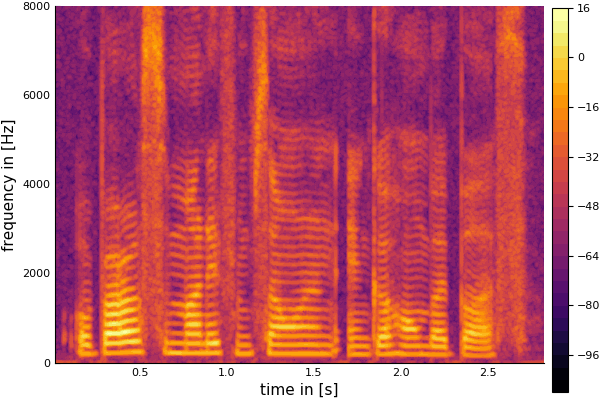

In [11]:
# analysis procedure with parameters `fl` (frame length) and `fs` (frame shift)
function my_analysis(audio::SSP.Audio; fl=32e-3, fs=8e-3)
    faudio = Sheet1.my_windowing(audio,frame_length=fl, frame_shift=fs)
    faudio = Sheet2.applyWindow(faudio, n -> Sheet2.myHann(n))
    Sheet2.my_spectrogram(Sheet2.my_stft(faudio))
end

my_analysis(speech1)

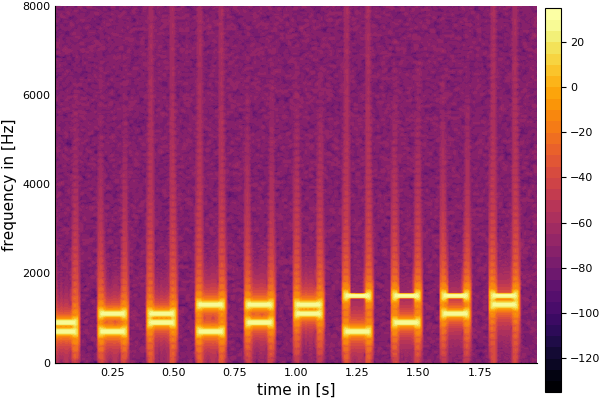

In [12]:
my_analysis(phone)

### (b)

The silent regions look like dark (say < -50 db) vertical stripes.

A voiced region is a bright vertical stripe with distinct very bright horizontal bars (which are peaks in the frequency domain) in the lower frequencies.

An unvoiced region a bright vertical stripe which is closer to uniform brightness in the sense that it doesn't contain the bright bars of a voiced region.

The lack of bars makes it very _easy to distinguish unvoiced from voiced regions_ when looking at the spectrogram.
The amplitude of the signal however cannot be determined upon first glance, which makes it a bit harder to make out silent regions and a lot _harder to tell the precise amplitude_ of a segment.

### (c)

We redefine the global variables `fl` and `fs` and rerun the analysis.

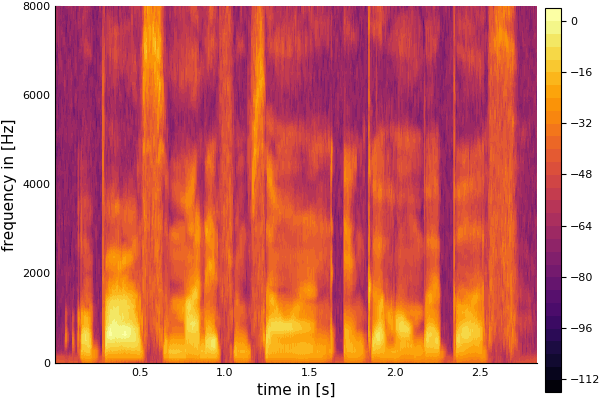

In [13]:
my_analysis(speech1, fl=8e-3, fs=2e-3)

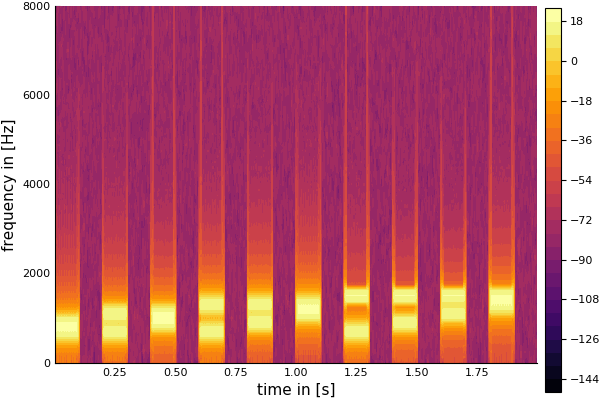

In [14]:
my_analysis(phone, fl=8e-3, fs=2e-3)

Description: The frame length is so short that each frame doesn't look very periodic. Thus you can see that the bars are less marked.

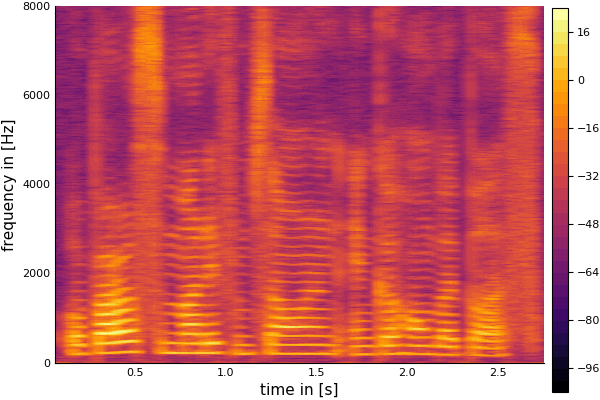

In [15]:
my_analysis(speech1, fl=128e-3, fs=32e-3)

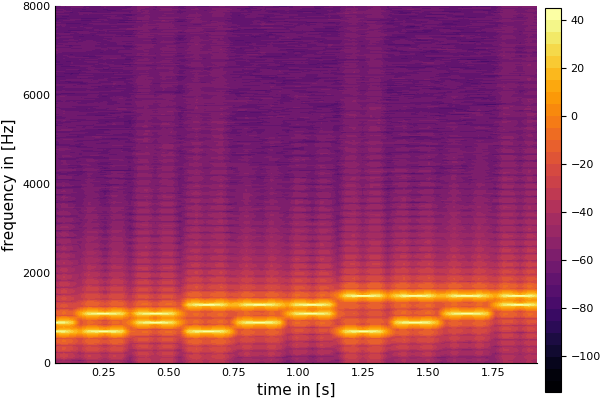

In [16]:
my_analysis(phone, fl=128e-3, fs=32e-3)

Description: The frame length is so long that low-timescale features (small pauses, short impulses) are hard to make out, as they get averaged out. However, whenever there is periodicity in the time domain (a voiced region), it is easy to tell the fundamental frequency.

### (d)

Here we plot the lower part of the spectrogram and overlay the frequency estimate from exercise 1.
Further we plot the second and third harmonics to see how well they match.

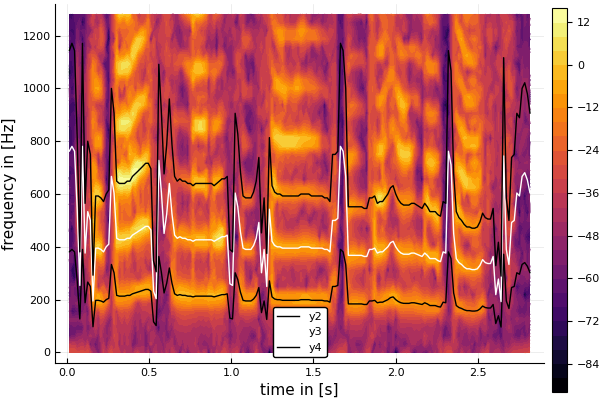

In [17]:
function my_ff_analysis(audio)
    faudio = Sheet1.my_windowing(audio)
    faudio = Sheet2.applyWindow(faudio, n -> sqrt.(Sheet2.myHann(n)))
    p = Sheet2.my_spectrogram(Sheet2.my_stft(faudio), maxfreq=1300)
    ts, ffs = Sheet1.fundamentalFrequencyEstimator(faudio)
    plot!(p, ts, ffs, color="black")
    plot!(p, ts, 2*ffs, color="white")
    plot!(p, ts, 3*ffs, color="black")
    p 
end

my_ff_analysis(speech1)

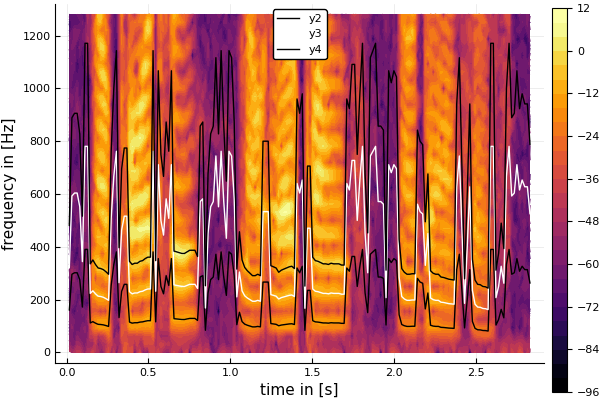

In [18]:
speech2 = SSP.loadAudio("./Exercise1/speech2.wav")
my_ff_analysis(speech2)

## 3 Synthesis from the STFT domain (Inverse STFT)

In order to synthesise a signal from a STFT we need to implement an inverse STFT function and an inverse to the windowing function.

```julia
# ./JuliaImpl/Sheet2.jl
function my_inverse_stft(framedSpectrum :: FramedSpectrum)

    if numSamples(framedSpectrum) % 2 == 0
        spectra = cat(1, framedSpectrum.spectrum, framedSpectrum.spectrum[end-1:-1:2,:,:])
    else
        spectra = cat(1, framedSpectrum.spectrum, framedSpectrum.spectrum[end:-1:2,:,:])
    end

    signal_frames = zeros(numSamples(framedSpectrum),
                          numTracks(framedSpectrum),
                          numFrames(framedSpectrum));
    for i in 1:numFrames(framedSpectrum)
        frame = spectra[:,:,i]
        signal_frames[:,:,i] = real.(ifft(frame))
    end
    FramedAudio(signal_frames, samplingRate(framedSpectrum), framedSpectrum.mean_time,
                framedSpectrum.spf, framedSpectrum.sps)
end

# ./JuliaImpl/Sheet2.jl
function my_inverse_windowing(faudio :: FramedAudio)
    signal  = zeros(faudio.spf + faudio.sps * (numFrames(faudio) - 1), numTracks(faudio))
    for i in 1:numFrames(faudio)
        frame                = faudio.frames[:,:,i]
        interval             = faudio.sps * (i-1) + (1:faudio.spf)
        signal[interval, :] += frame
    end

    loadAudio(signal, samplingRate(faudio))
end
```

To measure the error that is incured by going back and forth between time domain and frequency domain (roughly speaking), we view the difference $\varepsilon$ between the original and the transformed signal as a random variable and compute the mean $\mu$ as well as standard deviation $\sigma$.

In [19]:
function err(audio1, audio2)
    I = 1:min(SSP.numSamples(audio1), SSP.numSamples(audio2))
    audio1.samples[I,1] - audio2.samples[I,1]
end


function my_resynthesise(title::String, audio::SSP.Audio; window=n -> ones(n)/2)
    fspec = Sheet2.my_stft(Sheet2.applyWindow(Sheet1.my_windowing(audio),window))
    out = Sheet2.my_inverse_windowing(
        Sheet2.applyWindow(Sheet2.my_inverse_stft(fspec),window))
    ε = err(audio, out)
    println(title,": ", "μ(ε) = ", mean(ε), "\tσ(ε) = ", sqrt(var(ε)))
end

function testWindow(w)
    constantSignal = SSP.loadAudio(0.1 + zeros(60000),16000.)

    my_resynthesise("speech1.wav", speech1,window=w)
    my_resynthesise("phone.wav  ", phone, window=w)
    my_resynthesise("const.wav  ", constantSignal,window=w)
end

println("Constant window:")
testWindow(n -> ones(n)/2)
println("\nMy Hann window:")
testWindow(n -> sqrt.(Sheet2.myHann(n)))
println("\nHann window:")
testWindow(n -> sqrt.(Sheet2.hann(n)))
println("\nperiodic Hann window:")
testWindow(n -> sqrt.(Sheet2.hann(n,periodic=true)))

Constant window:
speech1.wav: μ(ε) = 7.150586720499938e-6	σ(ε) = 0.0057467593857243714
phone.wav  : μ(ε) = 8.497497482222345e-7	σ(ε) = 0.13753418346319135
const.wav  : μ(ε) = 0.05021367521367534	σ(ε) = 0.002301371690593125

My Hann window:
speech1.wav: μ(ε) = 5.462223062010355e-7	σ(ε) = 0.0046909185318571795
phone.wav  : μ(ε) = 2.3080536367874569e-7	σ(ε) = 0.12310383935256519
const.wav  : μ(ε) = 0.00042735042735043396	σ(ε) = 0.005645279945921786

Hann window:
speech1.wav: μ(ε) = 5.660729714057761e-7	σ(ε) = 0.0046944101928834475
phone.wav  : μ(ε) = 2.342159238623992e-7	σ(ε) = 0.12317297723772798
const.wav  : μ(ε) = 0.0006227673061071814	σ(ε) = 0.005640543163390155

periodic Hann window:
speech1.wav: μ(ε) = 5.462223062010355e-7	σ(ε) = 0.0046909185318571795
phone.wav  : μ(ε) = 2.3080536367874569e-7	σ(ε) = 0.12310383935256519
const.wav  : μ(ε) = 0.00042735042735043396	σ(ε) = 0.005645279945921786
